In [1]:
import re
from safe import SAFEConverter
import datamol as dm
from rdkit import Chem
from typing import Callable, List, Optional, Union

/nas/longleaf/home/shuhang/miniconda3/envs/f-rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from argo.gen_models.f_rag.fusion.slicer import MolSlicer,MolSlicerForSAFEEncoder

In [ ]:
import random

class SAFECodec:
    def __init__(self, 
                 slicer: Optional[Union[List[str], str, Callable]] = None, 
                 require_hs: Optional[bool] = False, 
                 ignore_stereo: bool = False
    ):
        """
        SAFE processor with encoder/decoder instances
        
        Args:
            slicer: Slicing algorithm for encoding, defaults to "brics"
                Supported slicers: ["hr", "rotatable", "recap", "mmpa", "attach", "brics"]
                Also custom slicers that return pairs of atom numbers
            require_hs (bool): whether the slicing algorithm require the molecule to have hydrogen explictly added
            ignore_stereo (bool): whether to remove stereochemistry before fragmenting
        """
        # Encoder converter with custom parameters
        self.encoder_conv = SAFEConverter(
            slicer=slicer,
            require_hs=require_hs,
            ignore_stereo=ignore_stereo
        )
        
        # Decoder converter using default params
        self.decoder_conv = SAFEConverter()

    def encode(self, inp: Union[str, dm.Mol], canonical=True):
        """Convert SMILES/molecule to SAFE string"""
        try:
            return self.encoder_conv.encoder(inp, canonical=canonical)
        except Exception as e:
            print(f"Unable to encode: {e}.")
            return None
        
    def encode_fragment(self, inp: Union[str, dm.Mol]):
        """Encode a fragment molecule to SAFE-formatted SMILES"""
        if isinstance(inp, str):
            inp = dm.to_mol(inp)

        if inp is None:
            return None
        
        if not isinstance(inp, dm.Mol):
            raise ValueError("Input must be a SMILES string or a RDKit molecule")
        
        non_map_atom_idxs = [
            atom.GetIdx() for atom in inp.GetAtoms() if atom.GetAtomicNum() != 0
        ]

        inp_smiles = Chem.MolToSmiles(
            inp,
            isomericSmiles=True,
            canonical=True,  # needs to always be true
            rootedAtAtom=non_map_atom_idxs[0],
        )

        # Remove any exit vector numbering
        #inp_smiles = self._canonicalize_frag(inp_smiles)

        attach_pos = set(re.findall(r"(\[\d+\*\]|!\[[^:]*:\d+\])", inp_smiles))
        for attach in attach_pos:
            inp_smiles = inp_smiles.replace(attach, '*')

        return inp_smiles # return SAFE-formatted SMILES for fragment
    
    def _canonicalize_frag(self, inp: Union[str, dm.Mol]):
        """Canonicalize a fragment molecule SMILES"""
        if isinstance(inp, dm.Mol):
            inp = dm.to_smiles(inp)
        if inp is None:
            return None
        return re.sub(r'\[\*:\d+\]', '*', inp)
    
    def decode(self, 
               inp: str, 
               as_mol=False,
               canonical=False,
               fix=True,
               remove_dummies=False,
               remove_added_hs=True
    ):
        """Convert SAFE string to SMILES"""
        try:
            return self.decoder_conv.decoder(inp, 
                                             as_mol=as_mol, 
                                             canonical=canonical, 
                                             fix=fix, 
                                             remove_dummies=remove_dummies, 
                                             remove_added_hs=remove_added_hs
            )
        except Exception as e:
            print(f'Decoding failed: {e}')
            return None
        
    def link_fragments(self, frag1: str, frag2: str):
        """Link two fragments SMILES together, randomly selecting a position to link"""
        frag1_sf = self.encode_fragment(frag1)
        frag2_sf = self.encode_fragment(frag2)
        
        frag1_sf_canon = self._canonicalize_frag(frag1_sf)
        frag2_sf_canon = self._canonicalize_frag(frag2_sf)

        # Randomly select a * in frag1_sf_canon and frag2_sf_canon
        # Find all * positions in each fragment
        single_bond_pattern = r'(?<!\=)\(\*\)|(?<!\=)\(\[\*\]\)|(?<!\=)\*'  # Matches single-bonded exit vectors, ignoring (=*) and =*
        #double_bond_pattern = r'=\*|\(=\*\)'  # Matches both =* and (=*)
        
        # Count stars to check if linking is possible
        if not re.search(single_bond_pattern, frag1_sf_canon) or not re.search(single_bond_pattern, frag2_sf_canon):
            return None
            
        # Replace one random * with %99 in each fragment
        # Find all positions of single bond exit vectors
        frag1_stars = [m.start() for m in re.finditer(single_bond_pattern, frag1_sf_canon)]
        frag2_stars = [m.start() for m in re.finditer(single_bond_pattern, frag2_sf_canon)]
        
        # Randomly select one position from each fragment
        frag1_pos = random.choice(frag1_stars)
        frag2_pos = random.choice(frag2_stars)
        
        # Replace the randomly selected positions with %99
        frag1_sf_canon = frag1_sf_canon[:frag1_pos] + '%99' + frag1_sf_canon[frag1_pos + len(re.match(single_bond_pattern, frag1_sf_canon[frag1_pos:]).group()):]
        frag2_sf_canon = frag2_sf_canon[:frag2_pos] + '%99' + frag2_sf_canon[frag2_pos + len(re.match(single_bond_pattern, frag2_sf_canon[frag2_pos:]).group()):]

        return self.decode(frag1_sf_canon + '.' + frag2_sf_canon, remove_dummies=False)
        
    '''
    def get_rings_from_safe(self, safe_str: str):
        """Get the substrings of SAFE strings that are rings in a list"""
        rings = []
        for safe_substr in safe_str.split('.'):
            decoded_smiles = self.decode(safe_substr)
            if decoded_smiles:
                frag = Chem.MolFromSmiles(decoded_smiles)
                if frag and any(atom.IsInRing() for atom in frag.GetAtoms()):
                    rings.append(safe_substr)  # Append the original SAFE substring

        return rings
    '''

In [72]:
slicer = MolSlicerForSAFEEncoder(shortest_linker=True)
sfcodec = SAFECodec(slicer=slicer, ignore_stereo=True)

In [93]:
smiles = 'Cc1cc(C)cc(OCC2CNC(=O)O2)c1'

In [94]:
sfcodec.encode(smiles)

'Cc1cc3cc(C)c1.C14CNC(=O)O1.O3C4'

In [95]:
sfcodec.decode('Cc1cc3cc(C)c1')

'Cc1cc([*:3])cc(C)c1'

In [76]:
sfcodec.decode('c12c(C)cccc1C', remove_dummies=False)

'c1([*:2])c(C)cccc1C'

In [77]:
sfcodec.encode_fragment('c1([*])c(C)cccc1C')

'c1(*)c(C)cccc1C'

In [78]:
sfcodec.decode('O=C(O)CCCCN(CC3)Cc1ccc(C(=O)O)cc1')

'O=C(O)CCCCN(CC[*:3])Cc1ccc(C(=O)O)cc1'

In [79]:
sfcodec.encode_fragment('O=C(O)CCCCN(CC[*])Cc1ccc(C(=O)O)cc1')

'O=C(O)CCCCN(CC*)Cc1ccc(C(=O)O)cc1'

In [80]:
sfcodec.link_fragments("O=C(O)CCCCN(CC[*:3])Cc1ccc(C(=O)O)cc1", "c1([*])c(C)cccc1C")

'O=C(O)CCCCN(CCc1c(C)cccc1C)Cc1ccc(C(=O)O)cc1'

In [90]:
sfcodec.link_fragments("Cc1csc(=N[*])n1[*]", "C#CCCN=c1scc([*])n1[*]") # random

'Cc1csc(=Nn2c(=NCCC#C)scc2*)n1*'

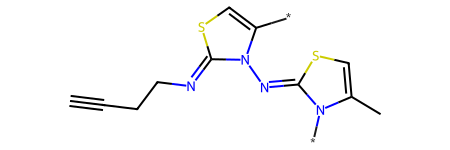

In [92]:
Chem.MolFromSmiles('Cc1csc(=Nn2c(=NCCC#C)scc2*)n1*')

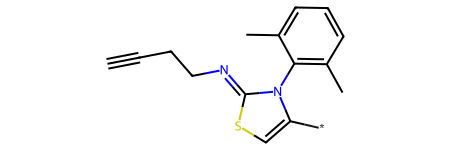

In [89]:
Chem.MolFromSmiles('C#CCCN=c1scc(*)n1-c1c(C)cccc1C')